In [16]:
# importing all proper libraries
import os
import numpy as np
import tensorflow as tf
import random 
from PIL import Image
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
#!pip install keras --upgrade

In [17]:
# listing available GPUs
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# Data stats

classes = list(sorted(os.listdir('/home/ubuntu/data/train')))

# Train/Test ratio
tr_ts = 6
print('Train to Test Ratio:',tr_ts)
total_ts = 0
total_train = 0

for ele in classes:
  class_info = os.listdir('/home/ubuntu/data/train/' + ele)
  tr_len = tr_ts * len(class_info) // (tr_ts+1)
  ts_len = len(class_info) - tr_len
  print(ele,'Train Length is',tr_len,'  ', 'Test Length is',ts_len)
  total_ts = total_ts + ts_len
  total_train = total_train + tr_len

print("Total Train:",total_train)
print("Total Test:",total_ts)




Train to Test Ratio: 6
c0 Train Length is 2133    Test Length is 356
c1 Train Length is 1943    Test Length is 324
c2 Train Length is 1986    Test Length is 331
c3 Train Length is 2010    Test Length is 336
c4 Train Length is 1993    Test Length is 333
c5 Train Length is 1981    Test Length is 331
c6 Train Length is 1992    Test Length is 333
c7 Train Length is 1716    Test Length is 286
c8 Train Length is 1638    Test Length is 273
c9 Train Length is 1824    Test Length is 305
Total Train: 19216
Total Test: 3208


In [19]:
# Creating partition of training and testing
partition = {'train': [], 
             'validation': []}

labels = {}
for ele in classes:
  class_pics = list(sorted(os.listdir('/home/ubuntu/data/train/' + ele)))
  tr_len = tr_ts * len(class_info) // (tr_ts+1)
  ts_len = len(class_info) - tr_len
   
  # appending id and labels for training 
  for imgs in class_pics[:tr_len]:
    partition['train'].append(ele + '/' + imgs)
    labels[ele + '/' + imgs] = ele[1:]

    
  
   # appending id and labels for testing
  for imgs in class_pics[tr_len:]:
    partition['validation'].append(ele + '/' + imgs)
    labels[ele + '/' + imgs] = ele[1:]

  
  # Check whether labels length match with partition vals

  assert len(partition['train']) + len(partition['validation']) == len(labels)




  

In [20]:
train_length = len(partition['train'])
test_length = len(partition['validation'])

print('Train to Test split is',train_length/test_length)

Train to Test split is 4.359464627151052


(480, 640, 3)


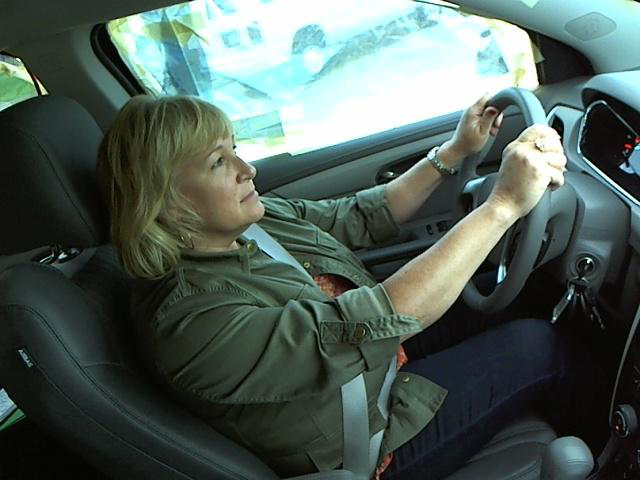

In [21]:
# Checking image pixel size and visualizing data
class_idx = str(random.randint(0,8))
img_idx = random.randint(0,10)

%matplotlib inline

imgs = os.listdir('/home/ubuntu/data/train/' + 'c' + class_idx)
img = imgs[img_idx]

#print(imgs)
im = Image.open('/home/ubuntu/data/train/' + 'c' + class_idx + '/' + img)
im_array = np.array(im)
print(im_array.shape)
im


In [22]:
# defining data generators
import numpy as np

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

# reference : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # X[i,] = np.load('data/' + ID + '.npy')
            
            # resize image to fit transfer learning
            X_img = Image.open('/home/ubuntu/data/train/' + ID )
            X_img = X_img.resize(size=(224,224))
            X[i,] = np.array(X_img)
            #print(i,ID)

            # Store class
            y[i] = self.labels[ID]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
# train the model and build architecture

import numpy as np
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.models import Sequential
import tensorflow


# Parameters
params = {'dim': (224,224),
          'batch_size': 32,
          'n_classes': 10,
          'n_channels': 3,
          'shuffle': True}

# Datasets
# partition # IDs
# labels # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)



# Transfer learn from VGG16 and imagenet weights

base_model = tensorflow.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


# freeze base
base_model.trainable = False



model = tf.keras.Sequential( [base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(10,activation="softmax")
                              ]
    
)

#model = multi_gpu_model(model,gpus=4)

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['Accuracy',tf.keras.metrics.CategoricalAccuracy()])

# model.fit(x=training_generator, validation_data=validation_generator)
history = model.fit(x=training_generator,epochs = 100 , validation_data = validation_generator)

In [ ]:
model.save('vgg_16_t1') # save model

# Test Accuracy

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Loading previous model and reconfirming validation data

In [26]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.models import Sequential
import tensorflow.keras



# Parameters
params = {'dim': (224,224),
          'batch_size': 1,
          'n_classes': 10,
          'n_channels': 3,
          'shuffle': False}

validation_generator = DataGenerator(partition['validation'], labels, **params)

In [27]:
model = tensorflow.keras.models.load_model('vgg_16_t1') # load model from saved weights

In [ ]:
# predict on validation
predict = model.predict(validation_generator)

predict.shape

predict_ = np.argmax(predict,axis=1)

# create stored value for truth labels
p = []
for ele in validation_generator:
    p.append(ele[1])


In [ ]:
# create pred and true arrays
y_true = np.array(p)

y_true.shape

y_true = np.argmax(y_true,axis=2)

y_true = y_true.flatten()

y_pred = predict_

In [ ]:
# create classificaton report
from sklearn.metrics import classification_report
import numpy as np


print(classification_report(y_true.ravel(), y_pred))

# Inferring on test data

In [54]:
import numpy as np

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

# Redfine datagenerator to access test images instead

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # X[i,] = np.load('data/' + ID + '.npy')

            X_img = Image.open('/home/ubuntu/data/test/' + ID )
            X_img = X_img.resize(size=(224,224))
            X[i,] = np.array(X_img)
            #print(i,ID)

            # Store class
            y[i] = self.labels[ID]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [45]:
partition["test"] = []
labels_ = {}

In [46]:
for ele in sorted(os.listdir('/home/ubuntu/data/test/')):
    partition["test"].append(ele)
    labels_[ele] = "0" # setting label of test data to dummy value to reuse Data Generator code

In [49]:
model.summary() # visualizing model info.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 14,719,818
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Parameters
params = {'dim': (224,224),
          'batch_size': 1,
          'n_classes': 10,
          'n_channels': 3,
          'shuffle': False}

test_generator = DataGenerator(partition['test'], labels_, **params) 

In [56]:
test_pred = model.predict(test_generator)

In [58]:
test_pred.shape

(79726, 10)

# Saving predictions as csv and self changing format in excel file

In [59]:
import numpy as np

a = np.array(test_pred)
np.savetxt('submission.csv', a, delimiter=',')